In [1]:
import numpy as np
import nltk
import pandas as pd

In [2]:
import re
import string
import pickle
from html import unescape

### Text Normalization

In [3]:
from nltk.corpus import wordnet as wn
import re
import string
import pickle
from html import unescape


stopword_list = nltk.corpus.stopwords.words('english')


stopword_list = stopword_list + 'mr mrs come go get tell listen one two three four five six seven seight nine zero join find make\
                 say ask tell se try back also'.split()

stopword_list = set(stopword_list)

CONTRACTION_MAP = pickle.load(open('contraction_map.pkl', 'rb'))

def tokenize_text(text):
    return [w.strip() for w in nltk.word_tokenize(text)]


def keep_text_characters(text):
    filtered_text = []
    for token in tokenize_text(text):
        if re.search('[a-zA-Z]', token):
            filtered_text.append(token)
    return " ".join(filtered_text)


def expand_contraction(text, mapping_dict):
    pattern = re.compile("({})".format("|".join(mapping_dict.keys())))
    
    def expand_match(match_obj):
        text = match_obj.group(0)
        expand_text = mapping_dict.get(text, mapping_dict.get(text.lower()))
        return text[0] + expand_text[1:]
    
    text = pattern.sub(expand_match, text)
    text = re.sub("'", "", text)
    return text
    
    
def lemmatize_text(text):
    wnl = nltk.WordNetLemmatizer()
    
    penn2wordnet = {'NN':wn.NOUN, 'JJ':wn.ADJ, 'VB':wn.VERB, 'RB':wn.ADV}    
        
    lemma_text = []
    for word, tag in nltk.pos_tag(nltk.word_tokenize(text)):
        wn_tag = penn2wordnet.get(tag[:2], "")
        if wn_tag:
            lemma_text.append(wnl.lemmatize(word.lower(), wn_tag))
        else:
            lemma_text.append(word)
    return " ".join(lemma_text)
    

def remove_special_characters(text):
    pattern = re.compile("[{}]".format(re.escape(string.punctuation)))
    return pattern.sub("", text)

def remove_stopwords(text):
    return " ".join(w for w in nltk.word_tokenize(text)  if w not in stopword_list)
    
    
def normalize_corpus(corpus, lemmatize=True, 
                     tokenize=False, only_text_chars=False):
    
    normalized_corpus = []
    for text in corpus:
        text = unescape(text)
        text = expand_contraction(text, CONTRACTION_MAP)
        
        if lemmatize:
            text = lemmatize_text(text).lower()
        else:
            text = text.lower()
            
        text = remove_special_characters(text)
        text = remove_stopwords(text)
        
        if only_text_chars:
            text = keep_text_characters(text)
            
        if tokenize:
            normalized_corpus.append(nltk.word_tokenize(text))
        else:
            normalized_corpus.append(text)
            
    return normalized_corpus

### Feature Extraction

In [4]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


def build_feature_matrix(corpus, feature_type='freq', 
                         ngram_range=(1, 1), min_df=0.0, max_df=1.0):
    
    if feature_type == 'binary':
        vec = CountVectorizer(binary=True, ngram_range=ngram_range, 
                              min_df=min_df, 
                              max_df=max_df)
    elif feature_type == 'freq':
        vec = CountVectorizer(binary=False, ngram_range=ngram_range, 
                              min_df=min_df, 
                              max_df=max_df)
    elif feature_type == 'tfidf':
        vec = TfidfVectorizer(ngram_range=ngram_range, 
                              min_df=min_df, max_df=max_df)
    else:
        raise ValueError("Invalid feature type [{}]: possible options [{}, {}, {}]".format(feature_type,
                                                                                           'binary', 
                                                                                          'freq', 
                                                                                          'tfidf'))
    matrix = vec.fit_transform(corpus)
    
    return vec, matrix

## Text Similarity
* term similarity: 
    * similarity between inidvidual tokens or words
* document similarity: 
    * similarity between entire text documents

### Analyzing Term Similarity

In [5]:
def vectorize_terms(terms):
    '''terms: a list of words'''
    return [np.array(list(map(ord, list(term.lower())))) for term in terms]

def boc_term_vectors(word_list):
    word_count_list = [pd.value_counts(list(word.lower())) for word in word_list]
    boc = pd.DataFrame(word_count_list).fillna(0).astype(int)
    return boc.columns, boc.values

In [6]:
root = 'Believe'
term1 = 'beleive'
term2 = 'bargain'
term3 = 'Elephant'

terms = [root, term1, term2, term3]

In [7]:
term_vecs = vectorize_terms(terms)

In [8]:
v, mat = boc_term_vectors(terms)

In [9]:
v

Index(['a', 'b', 'e', 'g', 'h', 'i', 'l', 'n', 'p', 'r', 't', 'v'], dtype='object')

In [10]:
mat

array([[0, 1, 3, 0, 0, 1, 1, 0, 0, 0, 0, 1],
       [0, 1, 3, 0, 0, 1, 1, 0, 0, 0, 0, 1],
       [2, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0],
       [1, 0, 2, 0, 1, 0, 1, 1, 1, 0, 1, 0]])

In [11]:
root_term = root
root_vec = term_vecs[0]
root_boc = mat[0]

In [12]:
terms = [term1, term2, term3]
vec_terms = term_vecs[1:]
boc_vec_terms = mat[1:]

### Hamming Distance

* $hd(u, v) = \sum_{i=1}^{n}(u_{i} \neq v_{i})$

* $norm\_hd(u, v) = \frac{\sum_{i=1}^{n}(u_{i} \neq v_{i})}{n}$

In [13]:
def hamming_distance(u, v, norm=False):
    assert u.shape == v.shape, "vectors must have equal lengths"
    diff = (u != v)
    return diff.mean() if norm else diff.sum()

In [14]:
for term, vec in zip(terms, vec_terms):
    try:
        print("Hamming distance between root: {} and term: {} is {:.4f}".format(root_term, 
                                                                                term, 
                                                                                hamming_distance(root_vec, vec, norm=True)))
    except AssertionError as e:
        print('error:',e, "::: len({}) != len({})".format(root_term, term))

Hamming distance between root: Believe and term: beleive is 0.2857
Hamming distance between root: Believe and term: bargain is 0.8571
error: vectors must have equal lengths ::: len(Believe) != len(Elephant)


### Manhattan Distance
* $md(u,v) = \sum_{i=1}^{n}|u_{i} - v_{i}|$
* $norm\_md(u,v) = \frac{\sum_{i=1}^{n}|u_{i} - v_{i}|}{n}$

In [15]:
def manhattan_distance(u, v, norm=False):
    assert u.shape == v.shape, "vectors must have equal lengths"
    diff = np.abs(u - v)
    return diff.mean() if norm else diff.sum()

In [16]:
for term, vec in zip(terms, vec_terms):
    try:
        print("Manhattan distance between root: {} and term: {} is {:.4f}".format(root_term, 
                                                                                term, 
                                                                                manhattan_distance(root_vec, vec, norm=True)))
    except AssertionError as e:
        print('error:',e, "::: len({}) != len({})".format(root_term, term))

Manhattan distance between root: Believe and term: beleive is 1.1429
Manhattan distance between root: Believe and term: bargain is 5.4286
error: vectors must have equal lengths ::: len(Believe) != len(Elephant)


### Euclidean Distance
* $ed(u,v) = \sqrt{\sum_{i=1}^{n}(u_{i}-v_{i})^2}$

In [17]:
def euclidean_distance(u, v):
    assert u.shape == v.shape, "vectors must have equal lengths"
    d = (u - v)
    return np.sqrt(np.dot(d, d))

In [18]:
for term, vec in zip(terms, vec_terms):
    try:
        print("Euclidean distance between root: {} and term: {} is {:.4f}".format(root_term, 
                                                                                term, 
                                                                                euclidean_distance(root_vec, vec)))
    except AssertionError as e:
        print('error:',e, "::: len({} != {})".format(len(root_term), len(term)))

Euclidean distance between root: Believe and term: beleive is 5.6569
Euclidean distance between root: Believe and term: bargain is 17.9444
error: vectors must have equal lengths ::: len(7 != 8)


### Levenshtein Edit Distance

In [19]:
import pandas as pd


def levenshtein_edit_distance(u, v):
    # convert to lower case
    u = u.lower()
    v = v.lower()
    
    # base case
    if u == v:
        return 0, None
    elif len(u) == 0:
        return len(v), None
    elif len(v) == 0:
        return len(u), None
    
    # initialize edit distance matrix
    edit_matrix = []
    # initialize two distance matrices
    du = [0] * (len(v) + 1)
    dv = [0] * (len(v) + 1)
    
    # du: the previous row of edit distances
    for i in range(len(du)):
        du[i] = i
    # dv: the current row of edit distances
    for i in range(len(u)):
        dv[0] = i+1
        # compute cost
        for j in range(len(v)):
            if u[i] == v[j]:
                cost = 0
            else:
                cost = 1
            dv[j+1] = min(dv[j]+1, du[j+1]+1, du[j] + cost)
            
        
        du = dv[:]
        edit_matrix.append(du[:])
    # compute the final edit distance and edit matrix
    distance = dv[-1]
    edit_matrix = np.array(edit_matrix).T
    edit_matrix = edit_matrix[1:, :]
    edit_matrix = pd.DataFrame(edit_matrix, columns=list(u), index=list(v))
    return distance, edit_matrix

In [20]:
for term in terms:
    d, edit_m = levenshtein_edit_distance(root_term, term)
    print("Distance between `{}` and `{}`: {}".format(root_term, term, d))
    print("The complete edit distance matrix:\n{}".format(edit_m))
    print('-'*50)

Distance between `Believe` and `beleive`: 2
The complete edit distance matrix:
   b  e  l  i  e  v  e
b  0  1  2  3  4  5  6
e  1  0  1  2  3  4  5
l  2  1  0  1  2  3  4
e  3  2  1  1  1  2  3
i  4  3  2  1  2  2  3
v  5  4  3  2  2  2  3
e  6  5  4  3  2  3  2
--------------------------------------------------
Distance between `Believe` and `bargain`: 6
The complete edit distance matrix:
   b  e  l  i  e  v  e
b  0  1  2  3  4  5  6
a  1  1  2  3  4  5  6
r  2  2  2  3  4  5  6
g  3  3  3  3  4  5  6
a  4  4  4  4  4  5  6
i  5  5  5  4  5  5  6
n  6  6  6  5  5  6  6
--------------------------------------------------
Distance between `Believe` and `Elephant`: 7
The complete edit distance matrix:
   b  e  l  i  e  v  e
e  1  1  2  3  4  5  6
l  2  2  1  2  3  4  5
e  3  2  2  2  2  3  4
p  4  3  3  3  3  3  4
h  5  4  4  4  4  4  4
a  6  5  5  5  5  5  5
n  7  6  6  6  6  6  6
t  8  7  7  7  7  7  7
--------------------------------------------------


### Cosine Distance and Similarity
* $cs(u, v) = \frac{u\cdot v}{\|u\| \|v\|}$
* $cd(u, v) = 1 - cs(u, v) = 1 - cos(\theta)$ 

In [21]:

def cosine_distance(u, v):
    cs = np.dot(u/np.linalg.norm(u), v/np.linalg.norm(v))
    return 1 - cs

In [22]:
for term, boc_term in zip(terms, boc_vec_terms):
    d = cosine_distance(root_boc, boc_term)
    print("Similarity between `{}` and `{}`:".format(root_term, term))
    print("Cosine distance: {:.4f}".format(1-d))
    print("Cosine similarity: {:.4f}".format(d))
    print('-'*50)

Similarity between `Believe` and `beleive`:
Cosine distance: 1.0000
Cosine similarity: 0.0000
--------------------------------------------------
Similarity between `Believe` and `bargain`:
Cosine distance: 0.1849
Cosine similarity: 0.8151
--------------------------------------------------
Similarity between `Believe` and `Elephant`:
Cosine distance: 0.6139
Cosine similarity: 0.3861
--------------------------------------------------


## Analyzing Document Similarity

In [23]:
toy_corpus = ['The sky is blue',
'The sky is blue and beautiful',
'Look at the bright blue sky!',
'Python is a great Programming language',
'Python and Java are popular Programming languages',
'Among Programming languages, both Python and Java are the most used in Analytics',
'The fox is quicker than the lazy dog',
'The dog is smarter than the fox',
'The dog, fox and cat are good friends']

query_docs = ['The fox is definitely smarter than the dog',
            'Java is a static typed programming language unlike Python',
            'I love to relax under the beautiful blue sky!']  

In [24]:
# normalize and extract features from the corpus
norm_corpus = normalize_corpus(toy_corpus, lemmatize=True)
tfidf_vec, tfidf_matrix = build_feature_matrix(norm_corpus, feature_type='tfidf')

In [25]:
norm_query_docs = normalize_corpus(query_docs, lemmatize=True)
query_docs_tfidf = tfidf_vec.transform(norm_query_docs)

In [26]:
query_docs_tfidf.shape, tfidf_matrix.shape

((3, 22), (9, 22))

### Cosine similarity

In [27]:
query_docs_tfidf[0].shape

(1, 22)

In [28]:
def compute_cosine_similarity(doc, corpus_matrix, top_n=3):
    
    doc = doc.toarray()[0]
    corpus_matrix = corpus_matrix.toarray()
    
    d_vec = np.dot(corpus_matrix, doc)
    top_idx = np.argsort(d_vec)[::-1][:top_n]
    return [(i, round(d_vec[i], 3)) for i in top_idx]

In [29]:
for i, doc in enumerate(query_docs):
    
    doc_tfidf = query_docs_tfidf[i]
    top_result = compute_cosine_similarity(doc_tfidf, tfidf_matrix, top_n=3)
    print("query doc: {}".format(doc))
    print('----------')
    print("matched docs:")
    print('------------')
    for j, score in top_result:
        print("score: {}".format(score))
        print("doc: {}".format(toy_corpus[j]))
    print('-'*50)

query doc: The fox is definitely smarter than the dog
----------
matched docs:
------------
score: 1.0
doc: The dog is smarter than the fox
score: 0.426
doc: The fox is quicker than the lazy dog
score: 0.37
doc: The dog, fox and cat are good friends
--------------------------------------------------
query doc: Java is a static typed programming language unlike Python
----------
matched docs:
------------
score: 0.733
doc: Python and Java are popular Programming languages
score: 0.58
doc: Among Programming languages, both Python and Java are the most used in Analytics
score: 0.498
doc: Python is a great Programming language
--------------------------------------------------
query doc: I love to relax under the beautiful blue sky!
----------
matched docs:
------------
score: 1.0
doc: The sky is blue and beautiful
score: 0.72
doc: The sky is blue
score: 0.426
doc: Look at the bright blue sky!
--------------------------------------------------


### Hellinger-Bhattacharya Distance
* $hbd(u, v) = \frac{1}{\sqrt{2}} \sqrt{\sum_{i=1}^{n}(\sqrt{u_{i}} - \sqrt{v_{i}})^2}$

In [30]:
def compute_hellinger_bhattacharya_distance(doc_feature, corpus_features, top_n=3):
    
    doc_feature = np.sqrt(doc_feature.toarray())
    corpus_features = np.sqrt(corpus_features.toarray())
    
    d_vec = np.sqrt(((corpus_features - doc_feature)**2).sum(axis=1) / 2.0)
    top_idx = np.argsort(d_vec)[:top_n]
    
    return [(i, round(d_vec[i], 3)) for i in top_idx]

In [31]:
for i, doc in enumerate(query_docs):
    
    print("query doc: {}".format(doc))
    print('---------')
    top_docs = compute_hellinger_bhattacharya_distance(query_docs_tfidf[i], tfidf_matrix, top_n=2)
    for j, score in top_docs:
        print("score: {:.4f}".format(score))
        print("doc: {}".format(toy_corpus[j]))
    print("-"*50)

query doc: The fox is definitely smarter than the dog
---------
score: 0.0000
doc: The dog is smarter than the fox
score: 0.9600
doc: The fox is quicker than the lazy dog
--------------------------------------------------
query doc: Java is a static typed programming language unlike Python
---------
score: 0.7020
doc: Python and Java are popular Programming languages
score: 0.9250
doc: Python is a great Programming language
--------------------------------------------------
query doc: I love to relax under the beautiful blue sky!
---------
score: 0.0000
doc: The sky is blue and beautiful
score: 0.6020
doc: The sky is blue
--------------------------------------------------


### Okapi BM25 Ranking

In [32]:
import scipy.sparse as sp


def compute_corpus_term_idfs(corpus_features, norm_corpus):
    '''
    parameters:
    ----------
    corpus_features : sparce matrix, shape[n_doc, n_term]
        bag of word features
    norm_corpus : list, [length = n_doc]
        list of documents
        
    return
    ------
    idfs : 1d-array, shape[n_term] 
        inverse document frequency(IDF) of the given corpus
    '''
    dfs = np.diff(sp.csc_matrix(corpus_features, copy=True).indptr) + 1
    C = len(norm_corpus) + 1
    
    idfs = 1 + np.log(C / dfs)
    return idfs


def compute_bm25_similarity(doc_features, corpus_features, 
                            corpus_doc_lengths, avg_doc_length,
                           term_idfs, k1=1.5, b=0.75, top_n=3):
    '''
    parameters:
    ----------
    doc_features: 1d-array, shape[n_term]
        query document feature vector
    corpus_features: sparse matrix, shape[n_doc, n_term]
        corpus bag of word feature matrix
    corpus_doc_lengths: int
        number of document in corpus
    avg_doc_length: float
        average term per doc in the corpus
    term_idfs: 1d-array, shape[n_term]
        inverse document frequency of the corpus
    '''
    # get bow matrix
    corpus_features = corpus_features.toarray()
    # get query term binary vector
    doc_features = doc_features.astype(bool).toarray()[0]
    
    assert corpus_features.shape[1] == len(doc_features)
    #print("Shape:\ncorpus_features: {}, doc_features: {}".format(corpus_features.shape, doc_features.shape))
    
    # idf(q) relate to the query
    assert term_idfs.shape == doc_features.shape
    idf = term_idfs * doc_features
    
    # compute bm25
    # denominator term
    denom = np.multiply(corpus_features, idf) * (k1+1)
    # numerator term
    numer = corpus_features + (k1*(1 - b + b*(corpus_doc_lengths / avg_doc_length))).reshape(-1, 1)
    
    # bm25 term
    bm25 = np.divide(denom, numer).sum(axis=1)
    #print(bm25)
    # get n best scores
    n_idx = np.argsort(bm25)[::-1][:top_n]
    
    # list of top_n (i, score)
    return [(i, round(bm25[i], 3)) for i in n_idx]

In [33]:
# build bag of words based features first
bow_vec, bow_matrix = build_feature_matrix(norm_corpus)
query_docs_bow = bow_vec.transform(norm_query_docs)

n_doc = len(norm_corpus)
corpus_doc_length = bow_matrix.toarray().sum(axis=1)
avg_doc_length = corpus_doc_length.mean()

corpus_idfs = compute_corpus_term_idfs(bow_matrix, norm_corpus)

In [34]:
for i, doc in enumerate(query_docs):
    
    doc_features = query_docs_bow[i]
    top_doc_idx = compute_bm25_similarity(doc_features, bow_matrix, 
                                          corpus_doc_length, avg_doc_length, 
                                          corpus_idfs, top_n=2)
    
    print('query doc: {}'.format(doc))
    print('='*10)
    for j, score in top_doc_idx:
        print("score: {:.4f}".format(score))
        print("doc: {}".format(toy_corpus[j]))
    print('-'*50)

query doc: The fox is definitely smarter than the dog
score: 7.3340
doc: The dog is smarter than the fox
score: 3.8800
doc: The fox is quicker than the lazy dog
--------------------------------------------------
query doc: Java is a static typed programming language unlike Python
score: 5.5010
doc: Python and Java are popular Programming languages
score: 4.5860
doc: Among Programming languages, both Python and Java are the most used in Analytics
--------------------------------------------------
query doc: I love to relax under the beautiful blue sky!
score: 7.3340
doc: The sky is blue and beautiful
score: 4.9840
doc: The sky is blue
--------------------------------------------------


### Document Clustering
#### Clustering Greatest Movies of All Time

In [35]:
import pandas as pd
import numpy as np

In [36]:
movie_data = pd.read_csv('movie_data.csv')

In [37]:
movie_data.head()

,Title,Synopsis
0,The Godfather,"In late summer 1945, guests are gathered for t..."
1,The Shawshank Redemption,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
2,Schindler's List,The relocation of Polish Jews from surrounding...
3,Raging Bull,"The film opens in 1964, where an older and fat..."
4,Casablanca,"In the early years of World War II, December 1..."


In [38]:
movie_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
Title       100 non-null object
Synopsis    100 non-null object
dtypes: object(2)
memory usage: 1.6+ KB


In [39]:
print(movie_data.iloc[0, 1][:1000])

In late summer 1945, guests are gathered for the wedding reception of Don Vito Corleone's daughter Connie (Talia Shire) and Carlo Rizzi (Gianni Russo). Vito (Marlon Brando), the head of the Corleone Mafia family, is known to friends and associates as "Godfather." He and Tom Hagen (Robert Duvall), the Corleone family lawyer, are hearing requests for favors because, according to Italian tradition, "no Sicilian can refuse a request on his daughter's wedding day." One of the men who asks the Don for a favor is Amerigo Bonasera, a successful mortician and acquaintance of the Don, whose daughter was brutally beaten by two young men because she refused their advances; the men received minimal punishment. The Don is disappointed in Bonasera, who'd avoided most contact with the Don due to Corleone's nefarious business dealings. The Don's wife is godmother to Bonasera's shamed daughter, a relationship the Don uses to extract new loyalty from the undertaker. The Don agrees to have his men punish 

In [40]:
# normalize corpus
norm_movie_synopses = normalize_corpus(movie_data['Synopsis'].values, lemmatize=True, only_text_chars=True)

In [41]:
norm_movie_synopses[0][:1000]

'late summer guest gather wedding reception vito corleones daughter connie talia shire carlo rizzi gianni russo vito marlon brando head corleone mafia family know friend associate godfather tom hagen robert duvall corleone family lawyer hear request favor accord italian tradition sicilian refuse request daughter wed day men favor amerigo bonasera successful mortician acquaintance whose daughter brutally beat young men refuse advance men receive minimal punishment disappoint bonasera whod avoid contact due corleones nefarious business dealing wife godmother bonaseras sham daughter relationship use extract new loyalty undertaker agree men punish young men responsiblemeanwhile young son michael al pacino decorated marine hero return world war ii service arrive wedding girlfriend kay adam diane keaton anecdotes family inform father criminal life reassure different family plan criminal dealing wed scene serf critical exposition remainder film michael introduce main character kay fredo john 

In [42]:
# extract tf-idf features
vectorizer, movie_matrix = build_feature_matrix(norm_movie_synopses, feature_type='tfidf', 
                                                ngram_range=(1, 2), min_df=.24, max_df=.85)

In [43]:
vectorizer

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.85, max_features=None, min_df=0.24,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [44]:
movie_matrix.shape

(100, 296)

In [45]:
feature_names = np.array(vectorizer.get_feature_names())

In [46]:
feature_names[:20]

array(['able', 'across', 'act', 'agree', 'alive', 'allow', 'alone',
       'along', 'already', 'although', 'always', 'another', 'anything',
       'apartment', 'appear', 'approach', 'arm', 'army', 'around', 'arrest'],
      dtype='<U12')

#### K-means Clustering

In [47]:
from sklearn.cluster import KMeans


def kmean(data, k=5):
    km = KMeans(n_clusters=k, max_iter=1000)
    km.fit(data)
    clusters = km.labels_
    return km, clusters

In [48]:
n_cluster = 5

km, clusters = kmean(movie_matrix, k=n_cluster)

In [49]:
movie_data['Cluster'] = clusters

In [50]:
movie_data.head()

,Title,Synopsis,Cluster
0,The Godfather,"In late summer 1945, guests are gathered for t...",2
1,The Shawshank Redemption,"In 1947, Andy Dufresne (Tim Robbins), a banker...",1
2,Schindler's List,The relocation of Polish Jews from surrounding...,1
3,Raging Bull,"The film opens in 1964, where an older and fat...",2
4,Casablanca,"In the early years of World War II, December 1...",0


In [51]:
pd.value_counts(clusters)

1    27
4    23
2    22
3    14
0    14
dtype: int64

In [52]:
a = km.cluster_centers_

In [53]:
a.argsort(axis=1)[:, ::-1]

array([[245, 135,  17, ..., 177,  12, 294],
       [269, 291, 135, ..., 186,   8,  41],
       [ 88,  90,  36, ...,  12, 164, 128],
       [156, 238,  93, ..., 136, 110,  19],
       [ 41, 230, 205, ..., 110,  77, 245]])

In [54]:
from sklearn.metrics.pairwise import cosine_distances
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
%matplotlib inline
import random
from matplotlib.font_manager import FontProperties


def get_cluster_data(clustering_obj, movie_data, 
                     feature_names, num_clusters, n_top=10):
    
    cluster_details = {}
    centroids = clustering_obj.cluster_centers_.argsort(axis=1)[:, ::-1]
    for i in range(num_clusters):
        d = {}
        d['cluster_num'] = i
        features = feature_names[centroids[i, :n_top]]
        d['feature_name'] = features
        titles = movie_data.loc[movie_data['Cluster']==i, 'Title'].values.tolist()
        d['movies'] = titles
        cluster_details[i] = d
    return cluster_details


def print_cluster_data(cluster_data):
    
    for cluster_id, detail in cluster_data.items():
        print("Cluster {}:".format(cluster_id))
        print('----------')
        print("Key features:\n\t[{}]".format(", ".join(detail['feature_name'])))
        print('Movies:\n\t{}'.format(", ".join(detail['movies'])))
        print('='*50)
        
def plot_clusters(num_clusters, feature_matrix, 
                  cluster_data, movie_data, 
                  plot_size=(16, 8)):
    
    # generate random clolor for clusters
    def generate_random_color():
        color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
        return color
    
    # markers for clusters
    markers = list("ov^<>8sp*hHDd")
    
    # similirality matrix
    cosine_dist = cosine_distances(feature_matrix)

    # dimensionality reduction
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
    xs, ys = mds.fit_transform(cosine_dist).T
    
    # build cluster plotting data
    cluster_color_map = {}
    cluster_name_map = {}
    for cluster_id, cluster_detail in cluster_data.items():
        cluster_color_map[cluster_id] = generate_random_color()
        cluster_name_map[cluster_id] = ", ".join(cluster_detail['feature_name'][:5]).strip()
        
    # Dataframe [x_pos, y_pos, cluster_label, title]
    cluster_plot_df = pd.DataFrame({'x': xs, 'y': ys, 
                                    'labels': movie_data['Cluster'].values, 
                                    'title': movie_data['Title'].values})
    
    grouped_cluster_df = cluster_plot_df.groupby('labels')
    
    # set plot figure size and axes
    fig, ax = plt.subplots(figsize=plot_size)
    ax.margins(0.05)
    # plot each cluster using coordinate and title
    for cluster_id, cluster_df in grouped_cluster_df:
        marker = markers[cluster_id] if cluster_id < len(markers) \
                else random.choice(markers)
        ax.plot(cluster_df['x'], cluster_df['y'], marker=marker, 
                color=cluster_color_map[cluster_id], linestyle='', 
               label=cluster_name_map[cluster_id], mec='none', ms=12)
    
    ax.set_aspect('auto')
    ax.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
    ax.tick_params(axis='y', which='both', bottom='off', top='off', labelbottom='off')
    
    fontP = FontProperties()
    fontP.set_size('small')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -.01), fancybox=True, 
              shadow=True, ncol=5, numpoints=1, prop=fontP)
    # add labels as the file titles
    for x, y, name in cluster_plot_df[['x', 'y', 'title']].values:
        ax.text(x, y, name, size=8)
    plt.show()

In [55]:
cluster_data = get_cluster_data(km, movie_data, feature_names, n_cluster)

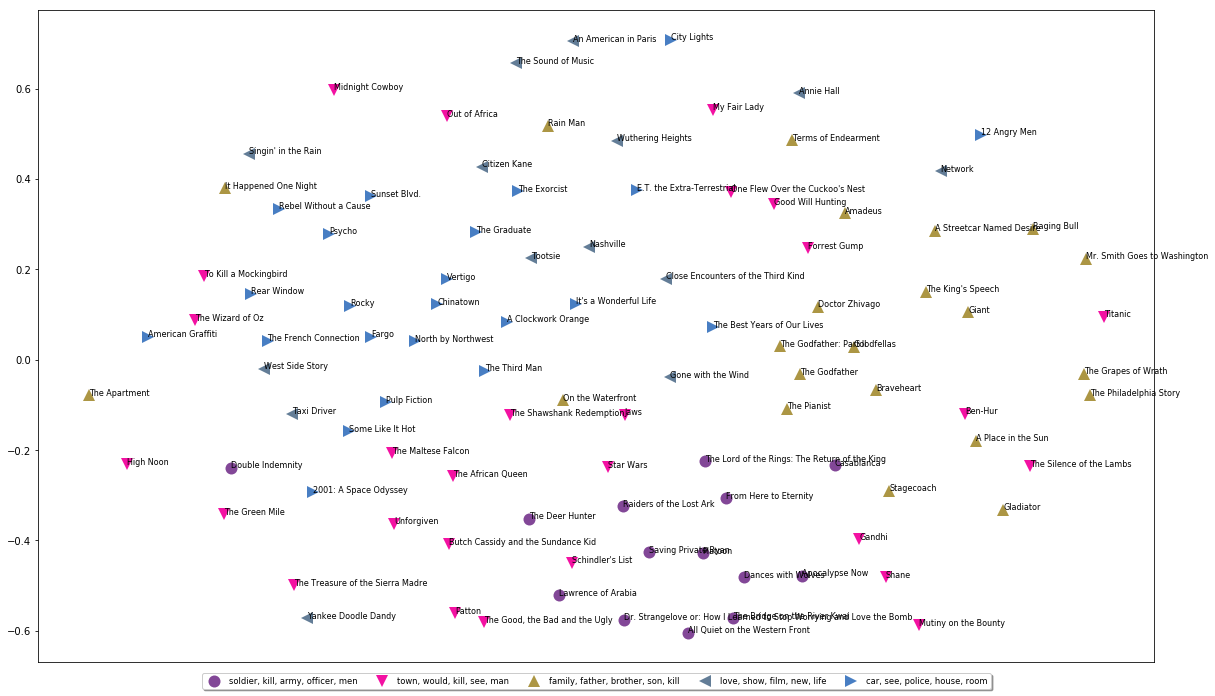

In [56]:
plot_clusters(n_cluster, movie_matrix, cluster_data, movie_data, plot_size=(20, 12))

In [57]:
print_cluster_data(cluster_data)

Cluster 0:
----------
Key features:
	[soldier, kill, army, officer, men, attack, shoot, order, war, return]
Movies:
	Casablanca, Lawrence of Arabia, The Bridge on the River Kwai, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, Apocalypse Now, The Lord of the Rings: The Return of the King, From Here to Eternity, Saving Private Ryan, Raiders of the Lost Ark, Platoon, Dances with Wolves, The Deer Hunter, All Quiet on the Western Front, Double Indemnity
Cluster 1:
----------
Key features:
	[town, would, kill, see, man, good, time, guard, woman, return]
Movies:
	The Shawshank Redemption, Schindler's List, One Flew Over the Cuckoo's Nest, The Wizard of Oz, Titanic, Forrest Gump, Star Wars, The Silence of the Lambs, Gandhi, Unforgiven, To Kill a Mockingbird, My Fair Lady, Ben-Hur, Patton, Jaws, The Good, the Bad and the Ugly, Butch Cassidy and the Sundance Kid, The Treasure of the Sierra Madre, High Noon, Midnight Cowboy, Out of Africa, Good Will Hunting, Shane, The Gree

### Affinity Propagation

In [59]:
from sklearn.cluster import AffinityPropagation


def affinity_propagation(feature_matrix):
    sim = feature_matrix * feature_matrix.T
    sim = sim.todense()
    
    ap = AffinityPropagation()
    ap.fit(sim)
    clusters = ap.labels_
    return ap, clusters

In [65]:
ap, clusters = affinity_propagation(movie_matrix)
n_cluster = np.unique(clusters).shape[0]

movie_data['Cluster'] = clusters
# clustering_obj, movie_data, feature_names, num_cluster 

cluster_data = get_cluster_data(ap, movie_data, feature_names, n_cluster, n_top=5)

In [62]:
pd.value_counts(clusters)

2     14
6      9
5      9
4      7
3      7
0      6
13     6
7      6
14     5
11     5
15     5
12     4
10     4
1      4
16     3
9      3
8      3
dtype: int64

In [66]:
np.unique(clusters).shape[0]

17

In [67]:
print_cluster_data(cluster_data)

Cluster 0:
----------
Key features:
	[able, another, day, escape, chase]
Movies:
	The Godfather, Gone with the Wind, The Godfather: Part II, Doctor Zhivago, The Pianist, Goodfellas
Cluster 1:
----------
Key features:
	[allow, arrest, city, across, explain]
Movies:
	Casablanca, One Flew Over the Cuckoo's Nest, The Silence of the Lambs, Good Will Hunting
Cluster 2:
----------
Key features:
	[appear, fire, first, feel, enter]
Movies:
	The Shawshank Redemption, Psycho, Sunset Blvd., Vertigo, West Side Story, It's a Wonderful Life, Rocky, Tootsie, Nashville, The Graduate, The Maltese Falcon, A Clockwork Orange, Rear Window, The Third Man
Cluster 3:
----------
Key features:
	[believe, claim, city, discuss, approach]
Movies:
	Citizen Kane, Forrest Gump, Amadeus, Braveheart, The Exorcist, A Place in the Sun, Double Indemnity
Cluster 4:
----------
Key features:
	[board, could, bad, bring, boy]
Movies:
	The Bridge on the River Kwai, Dr. Strangelove or: How I Learned to Stop Worrying and Love the

In [68]:
ap.cluster_centers_.shape

(17, 100)

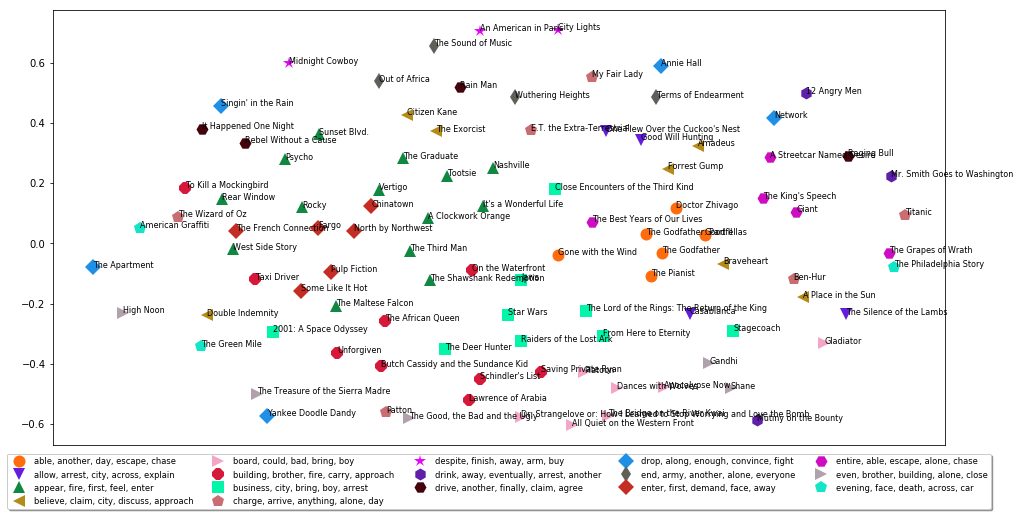

In [70]:
plot_clusters(n_cluster, movie_matrix, cluster_data, movie_data)

In [71]:
from sklearn.decomposition import LatentDirichletAllocation

In [109]:
vec, movie_tfidf = build_feature_matrix(norm_movie_synopses, feature_type='tfidf', 
                                        ngram_range=(1, 2), min_df=.24, max_df=.85)

In [110]:
names = np.array(vec.get_feature_names())
n_terms = 5

In [111]:
for cluster_id, detail in cluster_data.items():
    idx = (movie_data['Cluster'] == cluster_id).values
    
    lda = LatentDirichletAllocation(n_components=1, learning_method='online')
    lda.fit(movie_tfidf[idx])
    
    weights = lda.components_.ravel()
    idx = weights.argsort()[-n_terms:]
    
    print("Cluster {}:".format(cluster_id))
    print("----------")
    print("LDA: top words:\n\t[{}]".format(", ".join(names[idx])))
    print("Movies:\n\t{}".format(detail['movies']))
    print("="*50)

Cluster 0:
----------
LDA: top words:
	[business, war, brother, father, family]
Movies:
	['The Godfather', 'Gone with the Wind', 'The Godfather: Part II', 'Doctor Zhivago', 'The Pianist', 'Goodfellas']
Cluster 1:
----------
LDA: top words:
	[however, offer, lead, discover, escape]
Movies:
	['Casablanca', "One Flew Over the Cuckoo's Nest", 'The Silence of the Lambs', 'Good Will Hunting']
Cluster 2:
----------
LDA: top words:
	[look, house, apartment, police, see]
Movies:
	['The Shawshank Redemption', 'Psycho', 'Sunset Blvd.', 'Vertigo', 'West Side Story', "It's a Wonderful Life", 'Rocky', 'Tootsie', 'Nashville', 'The Graduate', 'The Maltese Falcon', 'A Clockwork Orange', 'Rear Window', 'The Third Man']
Cluster 3:
----------
LDA: top words:
	[kill, son, murder, death, father]
Movies:
	['Citizen Kane', 'Forrest Gump', 'Amadeus', 'Braveheart', 'The Exorcist', 'A Place in the Sun', 'Double Indemnity']
Cluster 4:
----------
LDA: top words:
	[attack, war, kill, officer, soldier]
Movies:
	['Th

In [114]:
'would' in stopword_list

False

### Ward's Agglomerative Hierarchical Clustering

In [128]:
from sklearn.metrics.pairwise import cosine_distances
from scipy.cluster.hierarchy import dendrogram, ward, linkage
from scipy.spatial.distance import pdist

In [150]:
def ward_hierarchical_clustering(feature_matrix):
    cosine_dist = pdist(movie_matrix.todense(), metric='cosine')
    #cosine_dist = cosine_distances(feature_matrix)
    return linkage(cosine_dist, method='ward')

def plot_hierarchical_clusters(linkage_matrix, movie_data, figure_size=(12, 8)):

    fig, ax = plt.subplots(figsize=figure_size)
    
    ax = dendrogram(linkage_matrix, orientation='left', labels=movie_data['Title'].values)
    
    plt.xticks([])
    fig.tight_layout()
    plt.savefig('ward_hierarchical_clusters.png', dpi=200)

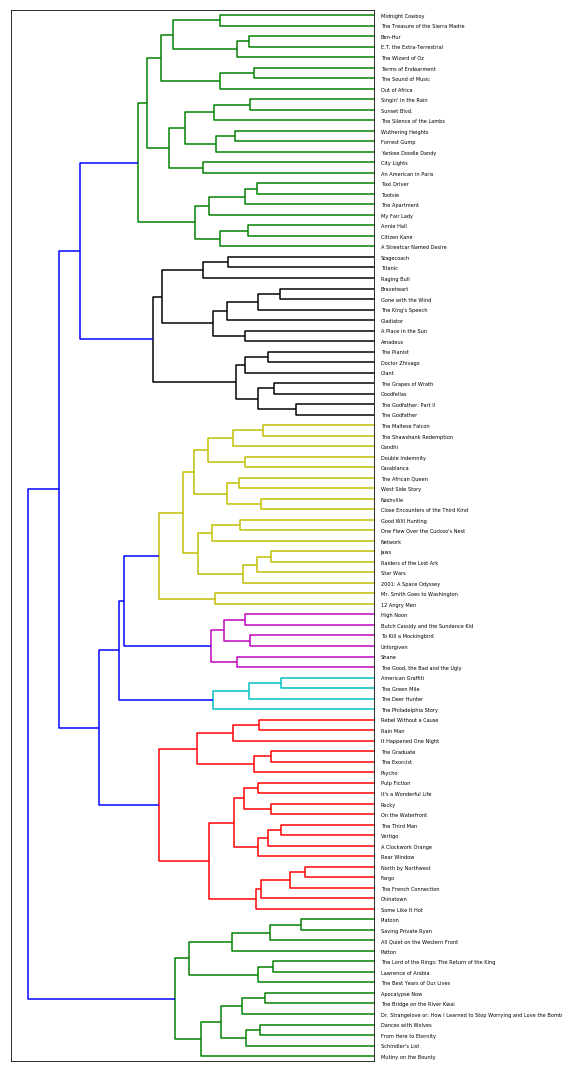

In [151]:
link = ward_hierarchical_clustering(movie_matrix)

plot_hierarchical_clusters(link, movie_data, figure_size=(8, 15))

In [154]:
1000/60

16.666666666666668